# Instacart Market Basket Analysis

## Which products will an Instacart consumer purchase again?

Kaggle Link: https://www.kaggle.com/c/instacart-market-basket-analysis

This notebook will serve as the analysis of the Instacart data. 

Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. 

In this Kaggle competition, Instacart is challenging the Kaggle community to use their anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order.

Lets begin ;-)

In [58]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import math
import gc

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Visualization tools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
color = sns.color_palette()

# Train/test split
from sklearn.model_selection import train_test_split

# Time checking
from time import time

## Lets load the data first

In [21]:
# List of products and relative information (product_id, aisle_id, department_id)
products = pd.read_csv('datasets/instacart/products.csv')

# This file tells to which set (prior, train, test) an order belongs
orders = pd.read_csv('datasets/instacart/orders.csv') 

train_orders = pd.read_csv('datasets/instacart/order_products__train.csv')
prior_orders = pd.read_csv('datasets/instacart/order_products__prior.csv')

# File that assign department_id to department name
departments = pd.read_csv('datasets/instacart/departments.csv')

# List of the different aisles (aisle_id -> aisle )
aisles = pd.read_csv('datasets/instacart/aisles.csv')

## Let us look at the data

In [22]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [23]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [24]:
prior_orders.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [25]:
train_orders.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [26]:
aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [27]:
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


As the data files are very large in size <b>(500MB+)</b> lets do some Data reduction (memory optimization)

Note: We will change some column types for less memory usage for the upcoming processing of data. 

In [28]:
print("products file types:")
print(products.dtypes, "\n")

print("orders file types:")
print(orders.dtypes, "\n")

print("train_orders types:")
print(train_orders.dtypes, "\n")

print("prior_orders types:")
print(prior_orders.dtypes, "\n")

print("deparments types:")
print(departments.dtypes, "\n")

print("aisles types:")
print(aisles.dtypes)

products file types:
product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object 

orders file types:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object 

train_orders types:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object 

prior_orders types:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object 

deparments types:
department_id     int64
department       object
dtype: object 

aisles types:
aisle_id     int64
aisle       object
dtype: object


<b>From this, one can infer:</b>

- Most of 'object' types can be converted to 'categorical' types. 
- 64 bytes is not necessary for almost all features, thus reducting this might be a good choice.
- 'float' objects can be casted to int when possible.

In [29]:
aisles['aisle'] = aisles['aisle'].astype('category')
aisles['aisle_id'] = aisles['aisle_id'].astype(np.int16)

departments['department'] = departments['department'].astype('category')
departments['department_id'] = departments['department_id'].astype(np.int16)

products['aisle_id'] = products['aisle_id'].astype(np.int16)
products['department_id'] = products['department_id'].astype(np.int16)
products['product_id'] = products['product_id'].astype(np.int16)
products['product_name'] = products['product_name'].astype('category')

orders['order_id'] = orders['order_id'].astype(np.int32)
orders['user_id'] = orders['user_id'].astype(np.int32)
orders['eval_set'] = orders['eval_set'].astype('category')
orders['order_number'] = orders['order_number'].astype(np.int16)
orders['order_dow'] = orders['order_dow'].astype(np.int16)
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype(np.int16)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(np.float16)

train_orders['order_id'] = train_orders['order_id'].astype(np.int32)
train_orders['product_id'] = train_orders['product_id'].astype(np.int32)
train_orders['add_to_cart_order'] = train_orders['add_to_cart_order'].astype(np.int16)
train_orders['reordered'] = train_orders['reordered'].astype(np.int16)

prior_orders['order_id'] = prior_orders['order_id'].astype(np.int32)
prior_orders['product_id'] = prior_orders['product_id'].astype(np.int32)
prior_orders['add_to_cart_order'] = prior_orders['add_to_cart_order'].astype(np.int16)
prior_orders['reordered'] = prior_orders['reordered'].astype(np.int16)

## Data Analysis (shapes)

In [30]:
print("products shape:", products.shape)
print("orders shape:", orders.shape)
print("train_orders shape:", train_orders.shape)
print("prior_orders shape:", prior_orders.shape)
print("departments shape:", dpmt.shape)
print("aisles shape", aisles.shape)

products shape: (49688, 4)
orders shape: (3421083, 7)
train_orders shape: (1384617, 4)
prior_orders shape: (32434489, 4)
departments shape: (21, 2)
aisles shape (134, 2)


### Null fields

In [31]:
print("Missing values in produts:", products.isnull().sum().sum())
print("Missing values in orders:", orders.isnull().sum().sum())
print("Missing values in train_orders:", train_orders.isnull().sum().sum())
print("Missing values in prior_orders:", prior_orders.isnull().sum().sum())

Missing values in produts: 0
Missing values in orders: 206209
Missing values in train_orders: 0
Missing values in prior_orders: 0


New explore the <b>orders</b> (dataset)

In [32]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

We can see that there are only missing values in the <b>days_since_prior_order</b> feature of the orders dataframe amongst the several files provided.

There are 3 evaluation sets: 'prior', 'train', 'test'.

'prior' refers to customers who had already bought from Instacart before, hence they have a user_id. 'prior' can be found several times from the same user, it just means that multiple previous orders are recorded.

Most importantly, these user classified in the 'prior' evaluation set have either a train or test label.

We need to separate the "true" test and test set from this valuable information.

<b>An example to understand visually how the problem is structured</b>

In [33]:
orders.loc[orders['user_id'] == 10, :]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
83,1224907,10,prior,1,2,14,NaN
84,68288,10,prior,2,5,15,30.0
85,2115522,10,prior,3,3,19,12.0
86,83395,10,prior,4,3,15,14.0
87,1353310,10,prior,5,5,20,23.0
88,1822501,10,train,6,0,19,30.0


In [34]:
# Gather user_id from 'train' evaluation set into a list
user_id_train = orders.loc[(orders['eval_set'] == 'train'), 'user_id'].values
# Collect all the orders, 'prior' included, from the train set
train_prior_orders = orders.loc[orders['user_id'].isin(user_id_train), :]

# We repeat this process for the 'test' evaluation set
user_id_test = orders.loc[(orders['eval_set'] == 'test'), 'user_id'].values
test_prior_orders = orders.loc[orders['user_id'].isin(user_id_test), :]

<b>Lets verify our findings</b>

In [35]:
train_prior_orders.head(6)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0


In [38]:
test_prior_orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [39]:
print(orders.groupby(['eval_set']).size(), "\n")
print(orders.groupby(['eval_set']).size()[1:].sum())

eval_set
prior    3214874
test       75000
train     131209
dtype: int64 

206209


There are <b>206,209</b> customers in total out of which the last purchase of <b>131,209</b> customers are given as train set and we need to predict for the rest <b>75,000</b> customers.

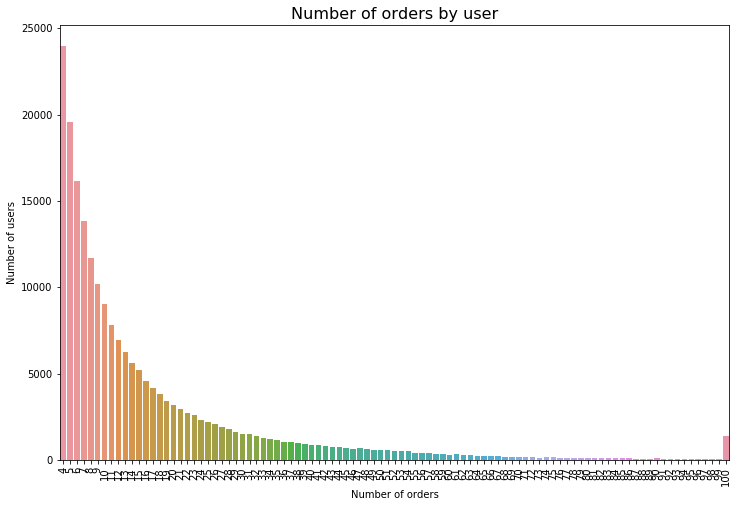

In [48]:
# Extract only 'train' and 'test' order_number
number_order = orders.loc[(orders['eval_set'] == 'train') | (orders['eval_set'] == 'test'), 'order_number']

plt.figure(figsize=(12,8))

sns.countplot(x=number_order.values)

plt.title('Number of orders by user', size=16)
plt.xlabel('Number of orders')
plt.ylabel('Number of users')
plt.xticks(rotation='vertical')
plt.show()

So the most common order size is <b>4 or 5</b>, but there are many orders which are much larger. In fact, 20-30 items per order is not unusual.

### More Analysis

Reorder relation to day of week
Does the reorder variable depend on the day of the week? We check below.

In [50]:
data = prior_orders.merge(orders, how='left', on='order_id')
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


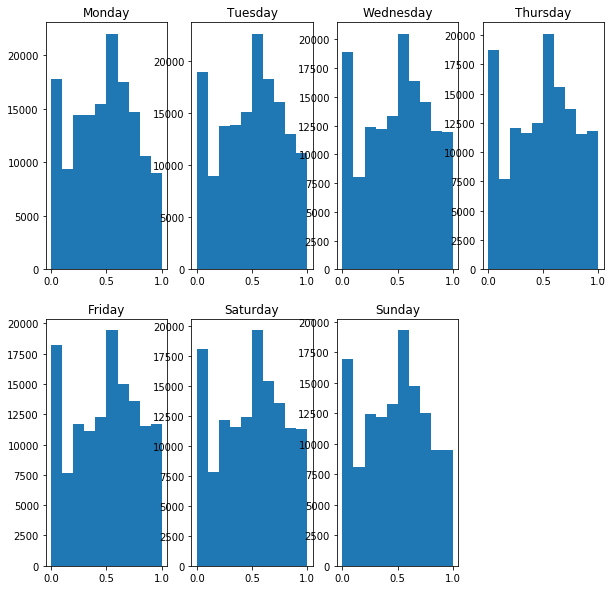

In [51]:
fig = plt.figure(figsize=(10, 10))
days = ['Monday', "Tuesday", 'Wednesday', "Thursday", "Friday", "Saturday", "Sunday"]
for i in range(7):
    ax = fig.add_subplot(2, 4, i+1)
    order_group = data[data.order_dow == i].groupby('user_id')
    info = order_group.reordered.sum() / order_group.reordered.size()
    ax.hist(info.values, range=(0, 1))
    ax.set_title(days[i])
plt.show()

At least on Friday and Saturday more people tend to reorder.

We also check if some users prefer some days for orders of certain products.

In [52]:
order_group = data.groupby(['user_id', 'product_id', 'order_dow'])
info = pd.DataFrame({'upo_per_day' : order_group.size()})
info = info.reset_index()

order_group = data.groupby(['user_id', 'product_id'])
info2 = pd.DataFrame({'upo_total' : order_group.size(), 'distinct_days' : order_group.order_dow.nunique()})
info2 = info2.reset_index()

info = info.merge(info2, how='left', on=['user_id', 'product_id'])
info['prob_order_per_day'] = info.upo_per_day / info.upo_total - 1 / info['distinct_days']
info.head()

,user_id,product_id,order_dow,upo_per_day,distinct_days,upo_total,prob_order_per_day
0,1,196,1,3,4,10,0.050000
1,1,196,2,2,4,10,-0.050000
2,1,196,3,2,4,10,-0.050000
3,1,196,4,3,4,10,0.050000
4,1,10258,1,3,4,9,0.083333


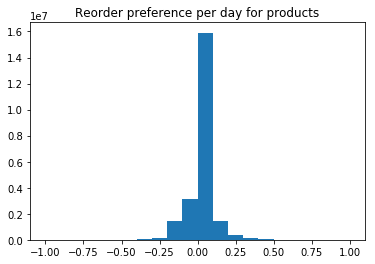

In [53]:
plt.hist(info.prob_order_per_day, range=(-1,1), bins=20)
plt.title('Reorder preference per day for products')
plt.show()

Conclusion: many products are bought at regular intervals.

### Time gap between reorders

We compute the number of days elapsed between consecutive orders of the same product.

In [54]:
data = orders.copy()
data.sort_values(by=['user_id', 'order_number'], inplace=True)
data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


The first step is to compute the number of days elapsed since the first order.

In [55]:
data.days_since_prior_order.fillna(0, inplace=True)
data['days_since_first_order'] = data.groupby('user_id').days_since_prior_order.cumsum(axis=0).reset_index(drop=True)
data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,0.0,0.0
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


We now join with the order information and process per product.

In [56]:
data = data.drop(['order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
data = data[data.eval_set == 'prior']
data = data.drop(['eval_set'], axis = 1)
data = prior_orders.merge(data, how='left', on='order_id')
data.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
data['days_since_op'] = data.days_since_first_order - data.days_since_first_order.shift(1)
data = data[data.reordered > 0]

We check the distribution of reorders as a function of days since previous order.

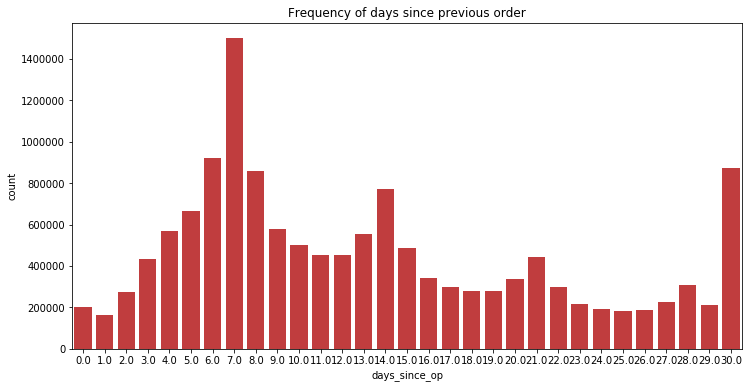

In [59]:
plt.figure(figsize=(12, 6))
sns.countplot(x="days_since_op", data=data[data.days_since_op <= 30], color=color[3])
plt.title('Frequency of days since previous order')
plt.show()

There are 3 peaks, at 7, 14 and 21 days. Of course, this might be because some people always order on Sundays, and always buy the the same products.

### Checkpoint

In [61]:
products.to_pickle('datasets/instacart/products.p')
orders.to_pickle('datasets/instacart/orders.p')
train_orders.to_pickle('datasets/instacart/order_products_train.p')
prior_orders.to_pickle('datasets/instacart/order_products_prior.p')
departments.to_pickle('datasets/instacart/departments.p')
aisles.to_pickle('datasets/instacart/aisle')

Loading the pickle file, analysis can start here and we don't have to process the previous code each time we come back

In [62]:
products = pd.read_pickle('datasets/instacart/products.p')
orders = pd.read_pickle('datasets/instacart/orders.p')
train_orders = pd.read_pickle('datasets/instacart/order_products_train.p')
prior_orders = pd.read_pickle('datasets/instacart/order_products_prior.p')
dpmt = pd.read_pickle('datasets/instacart/departments.p')
aisles = pd.read_pickle('datasets/instacart/aisle')

## Advance Analysis

First, let's fill the missing values in the days_since_prior_order feature. It corresponds to user's fist purchase.

In [63]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(np.int16)
prior_orders.head(4)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1


Now, let's regroup the features.

In [66]:
# Include user_id feature in train_orders
train_orders = train_orders.merge(orders[['user_id', 'order_id']], left_on='order_id', right_on='order_id', how='inner')

# Merge prior_orders and orders 
# 'inner' use intersetion of keys from both frames
orders_prior_merged = orders.merge(prior_orders, how='inner', on='order_id')
orders_prior_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0,196,1,0
1,2539329,1,prior,1,2,8,0,14084,2,0
2,2539329,1,prior,1,2,8,0,12427,3,0
3,2539329,1,prior,1,2,8,0,26088,4,0
4,2539329,1,prior,1,2,8,0,26405,5,0


In [67]:
orders_prior_merged.shape

(32434489, 10)

We will create features from the orders file

In [69]:
products_df = orders_prior_merged.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

# get the reorder frequency ('reordered' is just binary value)
products_df['reorder_frequency'] = products_df.groupby(['user_id', 'product_id']).cumcount()+1

# Extract items bought first and second for calculating probability for later
sub1 = products_df[products_df['reorder_frequency'] == 1].groupby('product_id').size().to_frame('bought_first')
sub2 = products_df[products_df['reorder_frequency'] == 2].groupby('product_id').size().to_frame('bought_second')

sub1['count_orders'] = products_df.groupby('product_id').size()
sub1['count_reorders'] = products_df.groupby('product_id')['reordered'].sum()

sub2 = sub2.reset_index().merge(sub1.reset_index())

# Calculate probability of being bought a second time
sub2['reorder_probability'] = sub2['bought_second'] / sub2['bought_first']

# Calculate ratio of reorder product
sub2['ratio_reorder'] = sub2['count_reorders'] / sub2['count_orders']
print(sub1.shape, sub2.shape,)

(49677, 3) (45305, 7)


In [70]:
products_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,reorder_frequency
0,2539329,1,prior,1,2,8,0,196,1,0,1
2,2539329,1,prior,1,2,8,0,12427,3,0,1
1,2539329,1,prior,1,2,8,0,14084,2,0,1
3,2539329,1,prior,1,2,8,0,26088,4,0,1
4,2539329,1,prior,1,2,8,0,26405,5,0,1


Saving relevant information in a separate dataframe

In [72]:
products_info_df = sub2[['product_id', 'count_orders', 'reorder_probability', 'ratio_reorder']]
products_info_df.head()

,product_id,count_orders,reorder_probability,ratio_reorder
0,1,1852,0.385475,0.613391
1,2,90,0.102564,0.133333
2,3,277,0.486486,0.732852
3,4,329,0.351648,0.446809
4,5,15,0.666667,0.600000


In [73]:
products_info_df.shape

(45305, 4)

We will create features from the orders file

In [74]:
orders.head(4)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,2398795,1,prior,2,3,7,15
2,473747,1,prior,3,3,12,21
3,2254736,1,prior,4,4,7,29


In [76]:
# Extract total number of orders
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('number_orders')

# Total number of days without purchasing
users['days_no_purchase'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()

# average interval between each purchase by user
users['mean_interval_purchase'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()
users.shape

(206209, 3)

In [78]:
# merging features about users and orders into one dataset
us = orders_prior_merged.groupby('user_id').size().to_frame('user_total_products')

us['eq_1'] = orders_prior_merged[orders_prior_merged['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_prior_merged[orders_prior_merged['order_number'] > 1].groupby('user_id')['product_id'].size()

# likelihood that user will buy again
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']

us.drop(['eq_1', 'gt_1'], axis=1, inplace=True)

# distinct products bought
us['user_distinct_products'] = orders_prior_merged.groupby(['user_id'])['product_id'].nunique()
us.shape

(206209, 3)

In [79]:
us.head(4)

,user_total_products,user_reorder_ratio,user_distinct_products
user_id,,,
1,59,0.759259,18
2,195,0.510989,102
3,88,0.705128,33
4,18,0.071429,17


In [80]:
users.head(4)

,number_orders,days_no_purchase,mean_interval_purchase
user_id,,,
1,10,176,17.600000
2,14,198,14.142857
3,12,133,11.083333
4,5,55,11.000000


In [81]:
users = users.reset_index().merge(us.reset_index(), how='inner')

# average basket size of each user
users['user_average_basket'] = users['user_total_products'] / users['number_orders']

# frame = orders[orders['eval_set'] != 'prior']
# frame = frame[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

frame = orders.loc[orders['eval_set'] != 'prior', ['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

users = users.merge(frame, how='inner')
users.shape

(206209, 11)

### Creating main file

Now that we regrouped our featured engineered our features, we can construct our final file.

In [152]:
orders_prior_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0,196,1,0
1,2539329,1,prior,1,2,8,0,14084,2,0
2,2539329,1,prior,1,2,8,0,12427,3,0
3,2539329,1,prior,1,2,8,0,26088,4,0
4,2539329,1,prior,1,2,8,0,26405,5,0


In [153]:
orders_prior_merged.shape

(32434489, 10)

In [154]:
# Group by product for each user
data_x = orders_prior_merged.groupby(['user_id', 'product_id']).size().to_frame('up_orders')

# min number of times item bought
data_x['up_first_order'] = orders_prior_merged.groupby(['user_id', 'product_id'])['order_number'].min()
# max number of times item bought
data_x['up_last_order'] = orders_prior_merged.groupby(['user_id', 'product_id'])['order_number'].max()
# when the item is taken 
data_x['up_average_cart_position'] = orders_prior_merged.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data_x = data_x.reset_index()
data_x.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333


In [155]:
data_x.shape

(13307953, 6)

In [156]:
users.head(4)

,user_id,number_orders,days_no_purchase,mean_interval_purchase,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,10,176,17.600000,59,0.759259,18,5.900000,1187899,train,14
1,2,14,198,14.142857,195,0.510989,102,13.928571,1492625,train,30
2,3,12,133,11.083333,88,0.705128,33,7.333333,2774568,test,11
3,4,5,55,11.000000,18,0.071429,17,3.600000,329954,test,30


In [157]:
# merge with products provided file to have product_name, aisle_id and department_id
# merging (products_info_df) and (users) dataframe constructed with data
data_x = data_x.merge(products_info_df, on='product_id')
data_x = data_x.merge(users, on='user_id')
data_x.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,days_no_purchase,mean_interval_purchase,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,176,17.6,59,0.759259,18,5.9,1187899,train,14


In [158]:
data_x.shape

(13278023, 19)

In [160]:
#user/ product combination features about the particular order
data_x['up_order_rate'] = data_x['up_orders'] / data_x['number_orders']
data_x['up_orders_since_last_order'] = data_x['number_orders'] - data_x['up_last_order']

data_x = data_x.merge(train_orders[['user_id', 'product_id', 'reordered']], \
                 how='left', on=['user_id', 'product_id'])
data_x.head(4)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,...,59,0.759259,18,5.9,1187899,train,14,1.0,0,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,...,59,0.759259,18,5.9,1187899,train,14,0.9,0,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,...,59,0.759259,18,5.9,1187899,train,14,0.1,5,NaN
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,...,59,0.759259,18,5.9,1187899,train,14,1.0,0,NaN


In [162]:
data_x.shape

(13278023, 22)

In [163]:
# merge with the products file provided to keep track of the product name
# aisle_id and department_id
data_x = data_x.merge(products, on='product_id')
data_x.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,product_name,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,...,5.900000,1187899,train,14,1.000000,0,1.0,Soda,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,...,3.272727,2161313,test,7,0.227273,0,NaN,Soda,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,...,22.666667,1735923,test,8,0.333333,2,NaN,Soda,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,...,6.212121,1854765,train,28,0.030303,23,NaN,Soda,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,...,14.950000,280888,test,18,0.100000,3,NaN,Soda,77,7


In [164]:
data_x.shape

(8645159, 25)

In [165]:
data_x.isnull().sum()

user_id                             0
product_id                          0
up_orders                           0
up_first_order                      0
up_last_order                       0
up_average_cart_position            0
count_orders                        0
reorder_probability                 0
ratio_reorder                       0
number_orders                       0
days_no_purchase                    0
mean_interval_purchase              0
user_total_products                 0
user_reorder_ratio              31301
user_distinct_products              0
user_average_basket                 0
order_id                            0
eval_set                            0
days_since_prior_order              0
up_order_rate                       0
up_orders_since_last_order          0
reordered                     8098822
product_name                        0
aisle_id                            0
department_id                       0
dtype: int64

In [166]:
data_x.dtypes

user_id                          int64
product_id                       int64
up_orders                        int64
up_first_order                   int16
up_last_order                    int16
up_average_cart_position       float64
count_orders                     int64
reorder_probability            float64
ratio_reorder                  float64
number_orders                    int16
days_no_purchase                 int16
mean_interval_purchase         float64
user_total_products              int64
user_reorder_ratio             float64
user_distinct_products           int64
user_average_basket            float64
order_id                         int32
eval_set                      category
days_since_prior_order           int16
up_order_rate                  float64
up_orders_since_last_order       int16
reordered                      float64
product_name                  category
aisle_id                         int16
department_id                    int16
dtype: object

In [170]:
#reduce the size by setting data types
data_x = data_x.astype(dtype= {'user_id' : np.uint32, \
                          'product_id': np.uint32, \
                          'up_orders' : np.uint16, \
                          'up_average_cart_position': np.uint16, \
                           'count_orders': np.int32, \
                           'reorder_probability': np.float16, \
                           'ratio_reorder': np.float16, \
                           'number_orders': np.uint8, \
                           'days_no_purchase': np.uint8, \
                           'mean_interval_purchase': np.uint8, \
                           'user_total_products': np.uint8, \
                           'user_reorder_ratio': np.float16, \
                           'order_id': np.uint32, \
                           'days_since_prior_order': np.uint8, \
                           'up_order_rate': np.float16, \
                           'up_orders_since_last_order': np.uint16
                          })

# replace NaN with zeros (not reordered) 
data_x['reordered'].fillna(0, inplace=True)  
data_x['reordered'] = data_x['reordered'].astype(np.uint8)

data_x['user_reorder_ratio'].fillna(0, inplace=True)
data_x['user_reorder_ratio'] = data_x['user_reorder_ratio'].astype(np.float16)
data_x.head(4)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,product_name,aisle_id,department_id
0,1,196,10,1,10,1,35791,0.58252,0.776367,10,...,5.900000,1187899,train,14,1.000000,0,1,Soda,77,7
1,15,196,5,15,22,2,35791,0.58252,0.776367,22,...,3.272727,2161313,test,7,0.227295,0,0,Soda,77,7
2,19,196,3,2,7,6,35791,0.58252,0.776367,9,...,22.666667,1735923,test,8,0.333252,2,0,Soda,77,7
3,21,196,1,10,10,2,35791,0.58252,0.776367,33,...,6.212121,1854765,train,28,0.030304,23,0,Soda,77,7


### Checkpoint

In [172]:
data.to_pickle('datasets/instacart/data.p')
data = pd.read_pickle('datasets/instacart/data.p')

### Split-out dataset

In [173]:
data.head(4)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders_x,reorder_probability_x,ratio_reorder_x,number_orders_x,...,user_average_basket_y,order_id_y,eval_set_y,days_since_prior_order_y,product_name_x,aisle_id_x,department_id_x,product_name_y,aisle_id_y,department_id_y
0,1,196,10,1,10,1,35791,0.5825,0.77648,10,...,5.900000,1187899,train,14,Soda,77,7,Soda,77,7
1,15,196,5,15,22,2,35791,0.5825,0.77648,22,...,3.272727,2161313,test,7,Soda,77,7,Soda,77,7
2,19,196,3,2,7,6,35791,0.5825,0.77648,9,...,22.666667,1735923,test,8,Soda,77,7,Soda,77,7
3,21,196,1,10,10,2,35791,0.5825,0.77648,33,...,6.212121,1854765,train,28,Soda,77,7,Soda,77,7


In [175]:
train_df = data_x[data_x['eval_set'] == 'train'].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)

test_df = data_x[data_x['eval_set'] == 'test'].drop(['eval_set', 'user_id', 'reordered'], axis=1)

In [176]:
test_df.shape

(3139290, 22)

In [177]:
train_df.shape

(5505869, 21)

In [178]:
train_df.head(4)

,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,days_no_purchase,mean_interval_purchase,...,user_reorder_ratio,user_distinct_products,user_average_basket,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,product_name,aisle_id,department_id
0,10,1,10,1,35791,0.58252,0.776367,10,176,17,...,0.759277,18,5.900000,14,1.000000,0,1,Soda,77,7
3,1,10,10,2,35791,0.58252,0.776367,33,61,9,...,0.515137,102,6.212121,28,0.030304,23,0,Soda,77,7
5,2,6,9,5,35791,0.58252,0.776367,11,104,9,...,0.415527,88,13.363636,26,0.181763,2,0,Soda,77,7
6,14,1,21,4,35791,0.58252,0.776367,27,236,8,...,0.724121,51,6.259259,3,0.518555,6,0,Soda,77,7


In [179]:
# Index.difference(other) -> Return a new Index with elements from the index that are not in other.
X = train_df[train_df.columns.difference(['reordered'])]
Y = train_df['reordered']

In [180]:
test_size = 0.20
seed = 46

X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [182]:
print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)

(4404695, 20) (4404695,)
(1101174, 20) (1101174,)


## Optimizing

Using MS LightGBM from https://github.com/Microsoft/LightGBM

Install using:

<code>C:\ProgramData\Anaconda3\Scripts>conda install -c conda-forge lightgbm</code>

In [184]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, label=y_train)
# reference (Other Dataset, optional) – If this dataset validation, need to use training data as reference
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

lgb_train

In [187]:
t0 = time()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',              # Gradient boosting tree algorithm
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000,              
    'max_bin' : 100,                      # Controls overfit
    'num_leaves': 512,                    # higher number of leaves
    'feature_fraction': 0.9,              # Controls overfit
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'min_data_in_leaf' : 200,             # Controls overfit
    'learning_rate' : 0.1
    #'device' : 'gpu',                     # Disable this if not using GPU
    #'gpu_use_dp' : True,                  # To make GPU use double precision
}

print('training LightGBM model ...')
lgb_model = lgb.train(params, 
                lgb_train,
                num_boost_round = 3000,     # 
                valid_sets = lgb_eval,     # Validation set used to prevent overfitting
                verbose_eval = 10,
                early_stopping_rounds=50)  # will stop the boost rounds if evaluation metricices didn't improve

t1 = time()
print("Time elapsed :", round((t1-t0)))

training LightGBM model ...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.831676	valid_0's binary_logloss: 0.348506
[20]	valid_0's auc: 0.832453	valid_0's binary_logloss: 0.272261
[30]	valid_0's auc: 0.833076	valid_0's binary_logloss: 0.253283
[40]	valid_0's auc: 0.833068	valid_0's binary_logloss: 0.24906
[50]	valid_0's auc: 0.832746	valid_0's binary_logloss: 0.248484
[60]	valid_0's auc: 0.832534	valid_0's binary_logloss: 0.248591
[70]	valid_0's auc: 0.832217	valid_0's binary_logloss: 0.248818
[80]	valid_0's auc: 0.831616	valid_0's binary_logloss: 0.24921
Early stopping, best iteration is:
[32]	valid_0's auc: 0.833149	valid_0's binary_logloss: 0.251806
Time elapsed : 150


In [199]:
X_test = test_df[test_df.columns.difference(['order_id', 'product_id'])]

test_df['reordered'] = lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration)
test_df.head(4)

,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,days_no_purchase,...,user_distinct_products,user_average_basket,order_id,days_since_prior_order,up_order_rate,up_orders_since_last_order,product_name,aisle_id,department_id,reordered
1,196,5,15,22,2,35791,0.58252,0.776367,22,227,...,13,3.272727,2161313,7,0.227295,0,Soda,77,7,0.246234
2,196,3,2,7,6,35791,0.58252,0.776367,9,76,...,133,22.666667,1735923,8,0.333252,2,Soda,77,7,0.220265
4,196,2,10,17,15,35791,0.58252,0.776367,20,93,...,190,14.950000,280888,18,0.099976,3,Soda,77,7,0.277981
10,196,7,3,14,2,35791,0.58252,0.776367,14,8,...,27,3.571429,139487,30,0.500000,0,Soda,77,7,0.205736


In [189]:
test_df.columns

Index(['product_id', 'up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'count_orders', 'reorder_probability',
       'ratio_reorder', 'number_orders', 'days_no_purchase',
       'mean_interval_purchase', 'user_total_products', 'user_reorder_ratio',
       'user_distinct_products', 'user_average_basket', 'order_id',
       'days_since_prior_order', 'up_order_rate', 'up_orders_since_last_order',
       'product_name', 'aisle_id', 'department_id', 'reordered'],
      dtype='object')

## Submit model

In [190]:
test_df.itertuples()

In [204]:
product_bag = dict()

for row in test_df.itertuples():
    #if row.reordered > 0.21: 
    # Cutoff for labeling product as positive
    try:
        # add a space if already one product
        product_bag[row.order_id] += ' ' + str(row.product_id)
    except:
        # 1st product
        product_bag[row.order_id] = str(row.product_id)

for order in test_df.order_id:
    if order not in product_bag:
        product_bag[order] = 'None'

submit = pd.DataFrame.from_dict(product_bag, orient='index')
submit.head(4)

submit.shape

(74903, 1)

In [202]:
submit.reset_index(inplace=True)
submit.head(4)

(74903, 2)

In [197]:
submit.columns = ['order_id', 'products']
submit.head(4)
submit.shape

(74903, 2)

In [196]:
submit.to_csv('datasets/instacart/submission.csv', index=False)